# 实现思路

## 框架

![framework](https://raw.githubusercontent.com/zhuojg/hacking-design-ai-2020/master/level02-1/images/framework.png)

## 思路

1. 将输入颜色（RGB值）转换到HSV色彩空间。
2. 根据H值和输入的分类方式对颜色进行分类，分类方式现在只实现了基于色相的分类，后续可以加入更多。
3. 根据H值、输入的搭配模式和需要的颜色数量计算搭配的H值，然后根据这些新的H值和原有的S和V值得到新的颜色。搭配模式根据色彩和谐模式进行选择，可以后续进一步扩充。
4. 将搭配颜色转换到RGB色彩空间，并用matplotlib可视化输入颜色和搭配颜色。

In [1]:
# import lib
import colorsys
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
# utils
def color_class_visualize(input_color):
    """
    :param input_color: should be rgb color, with value between [0, 255], like [126, 45, 200]
    """
    pass

def color_visualize(main_color, matched_colors):
    """
    :param main_color: user input color, should be rgb color, with value between [0, 255], like [126, 45, 200]
    :param matched_colors: matched colors calculated by the program
    :return: 
    """
    canvas = Image.new('RGB', (100 * color_number, 200), (255, 255, 255))
    draw = ImageDraw.Draw(canvas)
    for i, item in enumerate(matched_colors):
        draw.rectangle((i*100, 100, i* 100 + 100, 200), tuple(item))
    
    # add input color
    draw.rectangle((0, 0, 100 * color_number + 100, 100 ), tuple(main_color))

    return canvas

# 色彩分类模型

![color model](https://raw.githubusercontent.com/zhuojg/hacking-design-ai-2020/master/level02-1/images/colors.jpg)

In [3]:
def color_classification(input_color, mode='hue'):
    """
    :param input_color: should be rgb color, with value between [0, 255], like [126, 45, 200]
    :param mode: hue, xxx or xxx
    :return: the class input_color belongs to, calculated with rule of mode
    """
    if mode not in ['hue', 'emotion']:
        raise ValueError('Invalid color classification mode "%s"' % mode)
    
    color_class = None
    
    color_rgb = input_color
    color_hsv = list(colorsys.rgb_to_hsv(color_rgb[0], color_rgb[1], color_rgb[2]))
    # in colorsys, the v value belongs to [0, 255], but h and s belongs to [0, 1]
    # so convert them
    color_hsv[2] = color_hsv[2] / 255.
    
    if mode == 'hue':
        class_define = ['红', '橙', '黄', '黄绿', '绿', '青绿', '青', '天蓝', '蓝', '蓝紫', '紫', '紫红']
        hue = color_hsv[0]
        color_class = class_define[int(hue * 360 / 30)]
    elif mode == 'emotion':
        pass
    
    return color_class

In [4]:
def calculate_matched_hue(main_hue, cover_degree, number):
    """
    :param main_hue: 
    :param cover_degree: 
    :param number:
    :return: 
    """
    if number <= 0:
        return []
    
    result = []
    left_hue = main_hue - cover_degree / 360. / 2
    
    if left_hue < 0:
        left_hue += 1
        
    if number == 1:
        return [left_hue]
    
    # 当返回奇数个颜色，计算结果会包含原本的，所以多算一个
    num = number + number % 2
    
    for i in range(num):
        result.append(left_hue + cover_degree / (num - 1) / 360. * i)
    
    # 将多算的一个去掉
    if number % 2 == 1:
        del result[int(number/2)]
    
    # 如果hue值超过了[0, 1]的范围，则修正
    for i in range(len(result)):
        if result[i] < 0:
            result[i] += 1
        if result[i] > 1:
            result[i] -= 1
        
    return result
    
    
def color_match_harmony(input_color, mode='Y', number=4):
    """
    :param input_color: 
    :param mode: 
    :return: 
    """
    if mode not in ['i', 'V', 'L', 'I', 'T', 'Y', 'X']:
        raise ValueError('Invalid harmony color match mode "%s".' % mode)
    
    color_rgb = input_color
    color_hsv = list(colorsys.rgb_to_hsv(color_rgb[0], color_rgb[1], color_rgb[2]))
    color_hsv[2] = color_hsv[2] / 255.
    
    result_hue = None
    
    if mode == 'i':
        result_hue = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=18, number=number)
    elif mode == 'V':
        result_hue = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=93.6, number=number)
    elif mode == 'L':
        first_part_percentage = 18 / (18 + 79.2)
        first_part_num = int(number * first_part_percentage)
        first_part_num = first_part_num if first_part_num > 0 else (first_part_num + 1)
        result_hue_1 = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=18, number=first_part_num)
        second_hue = color_hsv[0] + 0.25
        second_hue = second_hue if second_hue <= 1 else (second_hue - 1)
        result_hue_2 = calculate_matched_hue(main_hue=second_hue, cover_degree=79.2, number=number - first_part_num)
        result_hue = result_hue_1 + result_hue_2
    elif mode == 'I':
        first_part_num = int(number / 2)
        result_hue_1 = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=18, number=first_part_num)
        opposite_hue = color_hsv[0] + 0.5
        opposite_hue = opposite_hue if opposite_hue <= 1 else (opposite_hue - 1)
        result_hue_2 = calculate_matched_hue(main_hue=opposite_hue, cover_degree=18, number=number - first_part_num)
        result_hue = result_hue_1 + result_hue_2
    elif mode == 'T':
        result_hue = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=180, number=number)
    elif mode == 'Y':
        second_part_percentage = 18 / (18 + 79.2)
        second_part_num = int(number * second_part_percentage)
        second_part_num = second_part_num if second_part_num > 0 else (second_part_num + 1)
        result_hue_1 = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=93.6, number=number - second_part_num)
        opposite_hue = color_hsv[0] + 0.5
        opposite_hue = opposite_hue if opposite_hue <= 1 else (opposite_hue - 1)
        result_hue_2 = calculate_matched_hue(main_hue=opposite_hue, cover_degree=18, number=second_part_num)
        result_hue = result_hue_1 + result_hue_2
    elif mode == 'X':
        first_part_num = int(number / 2)
        result_hue_1 = calculate_matched_hue(main_hue=color_hsv[0], cover_degree=93.6, number=first_part_num)
        opposite_hue = color_hsv[0] + 0.5
        opposite_hue = opposite_hue if opposite_hue <= 1 else (opposite_hue - 1)
        result_hue_2 = calculate_matched_hue(main_hue=opposite_hue, cover_degree=93.6, number=number - first_part_num)
        result_hue = result_hue_1 + result_hue_2
    else:
        raise ValueError('Invalid color match mode "%s".' % mode)
    
    result = []
    for item in result_hue:
        result.append([item, color_hsv[1], color_hsv[2]])
    
    for i, item in enumerate(result):
        rgb_color = list(colorsys.hsv_to_rgb(item[0], item[1], item[2]))
        for j in range(len(rgb_color)):
            rgb_color[j] = int(rgb_color[j] * 255)
        result[i] = rgb_color
    
    return result

Input color belongs to "蓝紫" according to mode "hue"
RGB for matched colors: [57, 9, 125], [125, 9, 78], [125, 9, 48], [125, 32, 9], [125, 63, 9], [125, 93, 9]


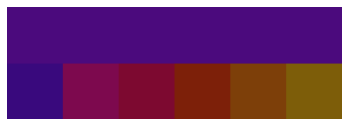

In [5]:
input_color = [75, 10, 125]
color_number = 6
color_classification_mode = 'hue'
color_match_mode = 'L'

# 根据输入颜色和颜色分类方式得到分类结果
category = color_classification(input_color, color_classification_mode)
print('Input color belongs to "%s" according to mode "%s"' % (category, color_classification_mode))

# 根据输入颜色、搭配模式和需要的颜色数量计算搭配颜色
result = color_match_harmony(input_color=input_color, mode=color_match_mode, number=color_number)
print('RGB for matched colors: %s' % ', '.join([str(item) for item in result]))
plt.figure()
plt.axis('off')
plt.imshow(color_visualize(input_color, result))